# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


In [200]:
## Import Libraries
import numpy as np
import pandas as pd

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import torch.optim as optim

from torchvision import datasets, transforms


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import adjusted_rand_score, accuracy_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

# Used to save data into files
import pickle as pkl
import os

# Used to measure time
import time

In [205]:
## Import train and test dataset, scale them and convert them to data loaders
BATCH_SIZE = 64

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)]),
    download=True,
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)]),
    download=True,
)
print(f"train_dataset:\n {train_dataset}")
print(f"test_dataset:\n {test_dataset}")

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_dataset:
 Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )
test_dataset:
 Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [3]:
## Randomly select some images from the training and test dataset

subset_size = 10000

## set a seed for randperm
th.manual_seed(42)

idx = th.randperm(len(train_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

train_subset_loader = DataLoader(train_dataset, sampler=sampler)

idx = th.randperm(len(test_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

test_subset_loader = DataLoader(train_dataset, sampler=sampler)

del(idx)
del(sampler)

In [4]:
## Convert the images and their labels to numpy arrays and reshape them to vectors
labels_train = []
train_subset = []
for batch in train_subset_loader:
    data, labels = batch
    
    train_subset.append(data.numpy().reshape(1, -1))
    labels_train.append(labels.numpy())

train_subset_scaled = np.array(train_subset).reshape(subset_size, -1)
labels_train = np.array(labels_train)

In [5]:
test_subset = []
labels_test = []

for batch in test_subset_loader:
    data, labels = batch
    
    test_subset.append(data.numpy().reshape(1, -1))
    labels_test.append(labels.numpy())

test_subset_scaled = np.array(test_subset).reshape(subset_size, -1)
labels_test = np.array(labels_test)

In [6]:
# Creating dictionary of labels for better understanding
description = {0: "T-shirt/top", 
               1: "Trouser", 
               2: "Pullover", 
               3: "Dress", 
               4: "Coat", 
               5: "Sandal", 
               6: "Shirt", 
               7: "Sneaker", 
               8: "Bag", 
               9: "Ankle boot"}

ticks = list(description.keys())
tick_labels = list(description.values())

In [7]:
## Defining functions to save and load data from pickle files

def save_data(data, filename):
    if not os.path.exists(filename):
        with open(filename, "wb") as f:
            pkl.dump(data, f)

def load_data(filename):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            data = pkl.load(f)
    return data

T-shirt/top: 1.0
Trouser: 4.0
Pullover: 3.0
Dress: 3.0
Coat: 3.0
Sandal: 4.0
Shirt: 6.0
Sneaker: 2.0
Bag: 2.0
Ankle boot: 2.0


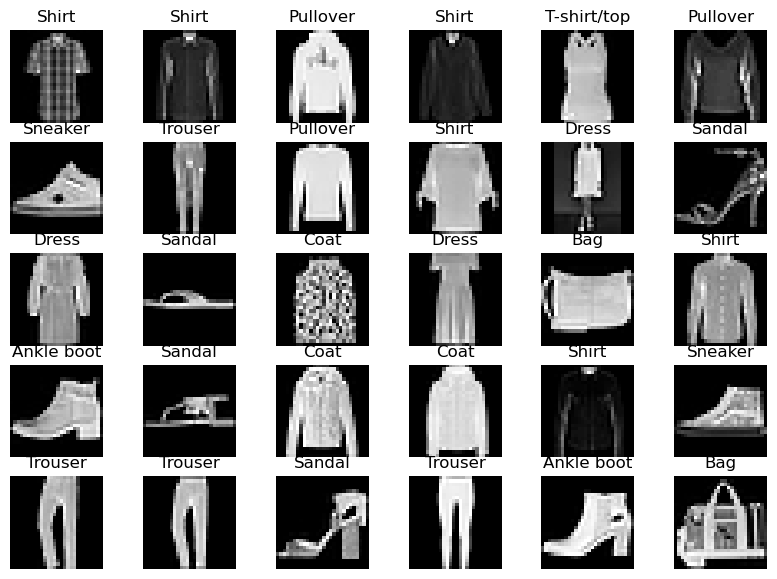

In [8]:
# Printing samples and checking labels
indices = np.random.choice(train_subset_scaled.shape[0], size=30, replace=False)


def print_img_index(indices, img_set, lab_set):
    counter = np.zeros(10)

    # Counting number of appearance of each label
    for i in range(len(indices)):
        label = lab_set[indices[i]]
        counter[label] += 1

    # Plotting the images with the labels as titles
    fig, axs = plt.subplots(5, 6, figsize=(10, 7))
    axs = axs.flatten()

    for i, idx in enumerate(indices):
        axs[i].imshow(
            img_set[idx].reshape(28, 28), cmap="gray"
        )  # Assuming images are 28x28 pixels
        axs[i].axis("off")  # Turn off axis labels for cleaner visualization
        # string = str(description[labels_subset[idx]])
        axs[i].set_title(description[lab_set[idx].item()])

    # Printing the counted amounts
    for j in range(10):
        print(f"{description[j]}: {counter[j]}")

print_img_index(indices, train_subset_scaled, labels_train)

## Exercise 1

In [9]:
# Choose the color map for the plots
colors_rgb = [(33,240,182), (21,122,72), (155,209,198), (16,85,138), (172,139,248), (133,22,87), (197,81,220), (56,181,252), (18,85,211), (171,230,91)]
colors_rgb_normalized = colors_rgb_normalized = np.array(colors_rgb) / 255.0
cmap = ListedColormap(colors_rgb_normalized)

In [10]:
## Perform linear PCA

model = PCA(n_components = 3)
data_pca_linear = model.fit_transform(train_subset_scaled)

del(model)

Text(0, 0.5, 'Principal Component 2')

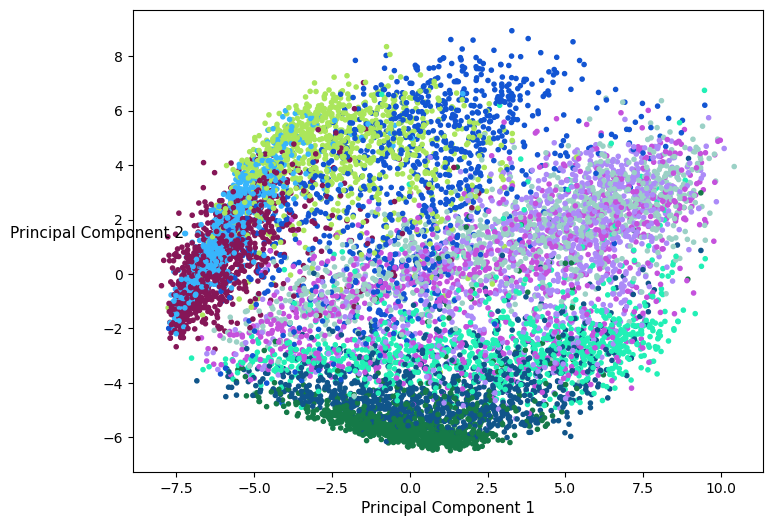

In [11]:
# Plot the first two principal components

fig = plt.figure(figsize=(9, 6))
plt.subplots_adjust(left=0.2)
p = plt.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], c = labels_train, marker='.', cmap = cmap)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11, rotation=0)


# Uncomment to plot the colorbar
# cb = plt.colorbar(p)
# cb.set_ticks(ticks)
# cb.set_ticklabels(tick_labels)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

# plt.savefig("Report/pca_linear_2comps.png")

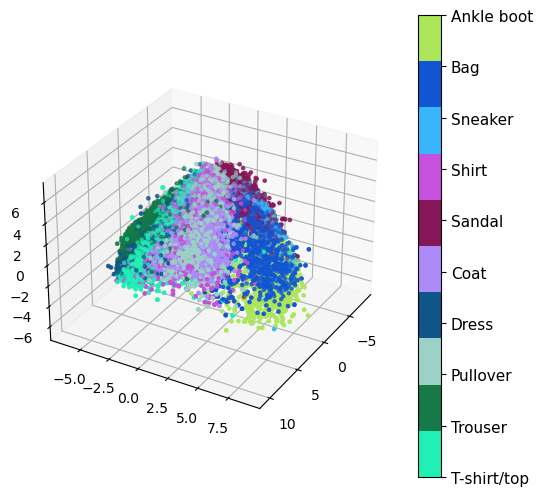

In [12]:
# Plot the first two principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], data_pca_linear[:, 2], c = labels_train, marker='.', cmap=cmap)
ax.view_init(elev=30, azim=30)


# Uncomment to show colorbar
cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
# cb.ax.set_title('Class', fontsize=11)
del(cb)

del(fig)
del(ax)
del(p)


# plt.savefig("Report/pca_linear_3comps.png")

#### Comment
The data does not seem to be well separated, so finding the right hyperplane for classification will be hard.

### 1.2: Perform kernel PCA

In [13]:
# Perform kernel pca using the RBF kernel
    
kernel_pca = KernelPCA(kernel="rbf", n_components = 3)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

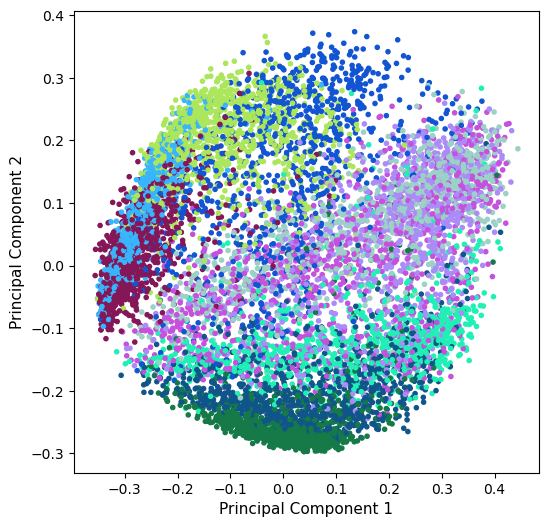

In [14]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_train, marker='.', cmap=cmap)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

del(p)
del(fig)
# plt.savefig("Report/pca_rbf_2comps.png")

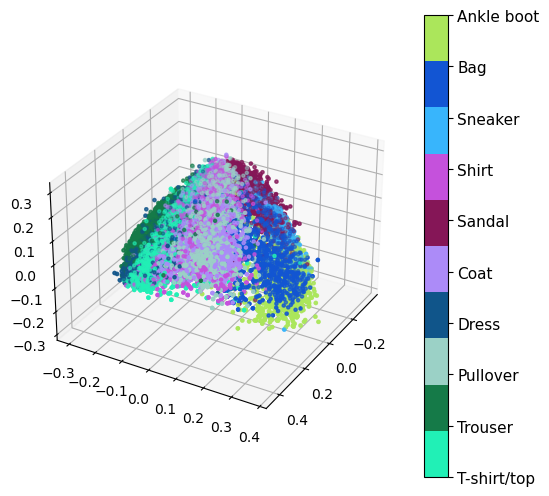

In [15]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], data_pca_rbf[:, 2], c = labels_train, marker='.', cmap=cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)
del(cb)

ax.view_init(elev=30, azim=30)

del(fig)
del(ax)
del(p)

# plt.savefig("Report/pca_rbf_3comps.png")

### Perform parameter tuning

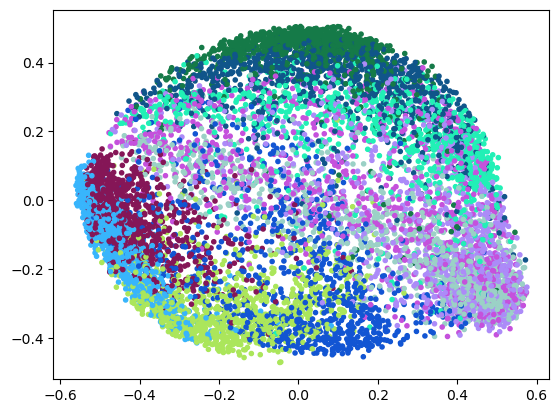

In [16]:
kernel_pca = KernelPCA(kernel = "rbf", n_components = 3, gamma = 5 / 784)
data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)

plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_train, marker='.', cmap=cmap)

In [17]:
# Perform kernel pca using the RBF kernel, tune gamma to separate clusters
    
gamma = np.array([(1/10)*(1/784), 1/784, 10 * (1/784)])

data_pca_rbf = np.ndarray((10000, 3, len(gamma)))

for i in range(len(gamma)):
    kernel_pca = KernelPCA(kernel = "rbf", n_components = 3, gamma = gamma[i])
    data_pca_rbf[:, :, i] = kernel_pca.fit_transform(train_subset_scaled)

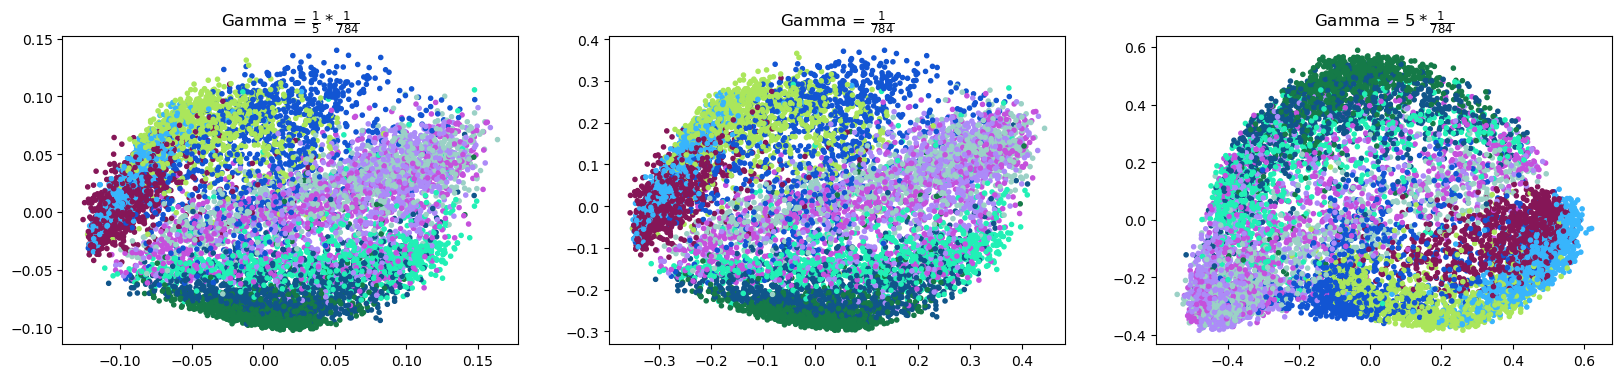

In [18]:
# scatterplot for different gammas

gammas = ["$\\frac{1}{5} * \\frac{1}{784}$", "$\\frac{1}{784}$", "$5 * \\frac{1}{784}$"]
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

for i, ax in enumerate(axs.flat):
    p = ax.scatter(data_pca_rbf[:, 0, i], data_pca_rbf[:, 1, i], c = labels_train, marker='.', cmap=cmap)
    ax.set_title('Gamma = ' + gammas[i])

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)

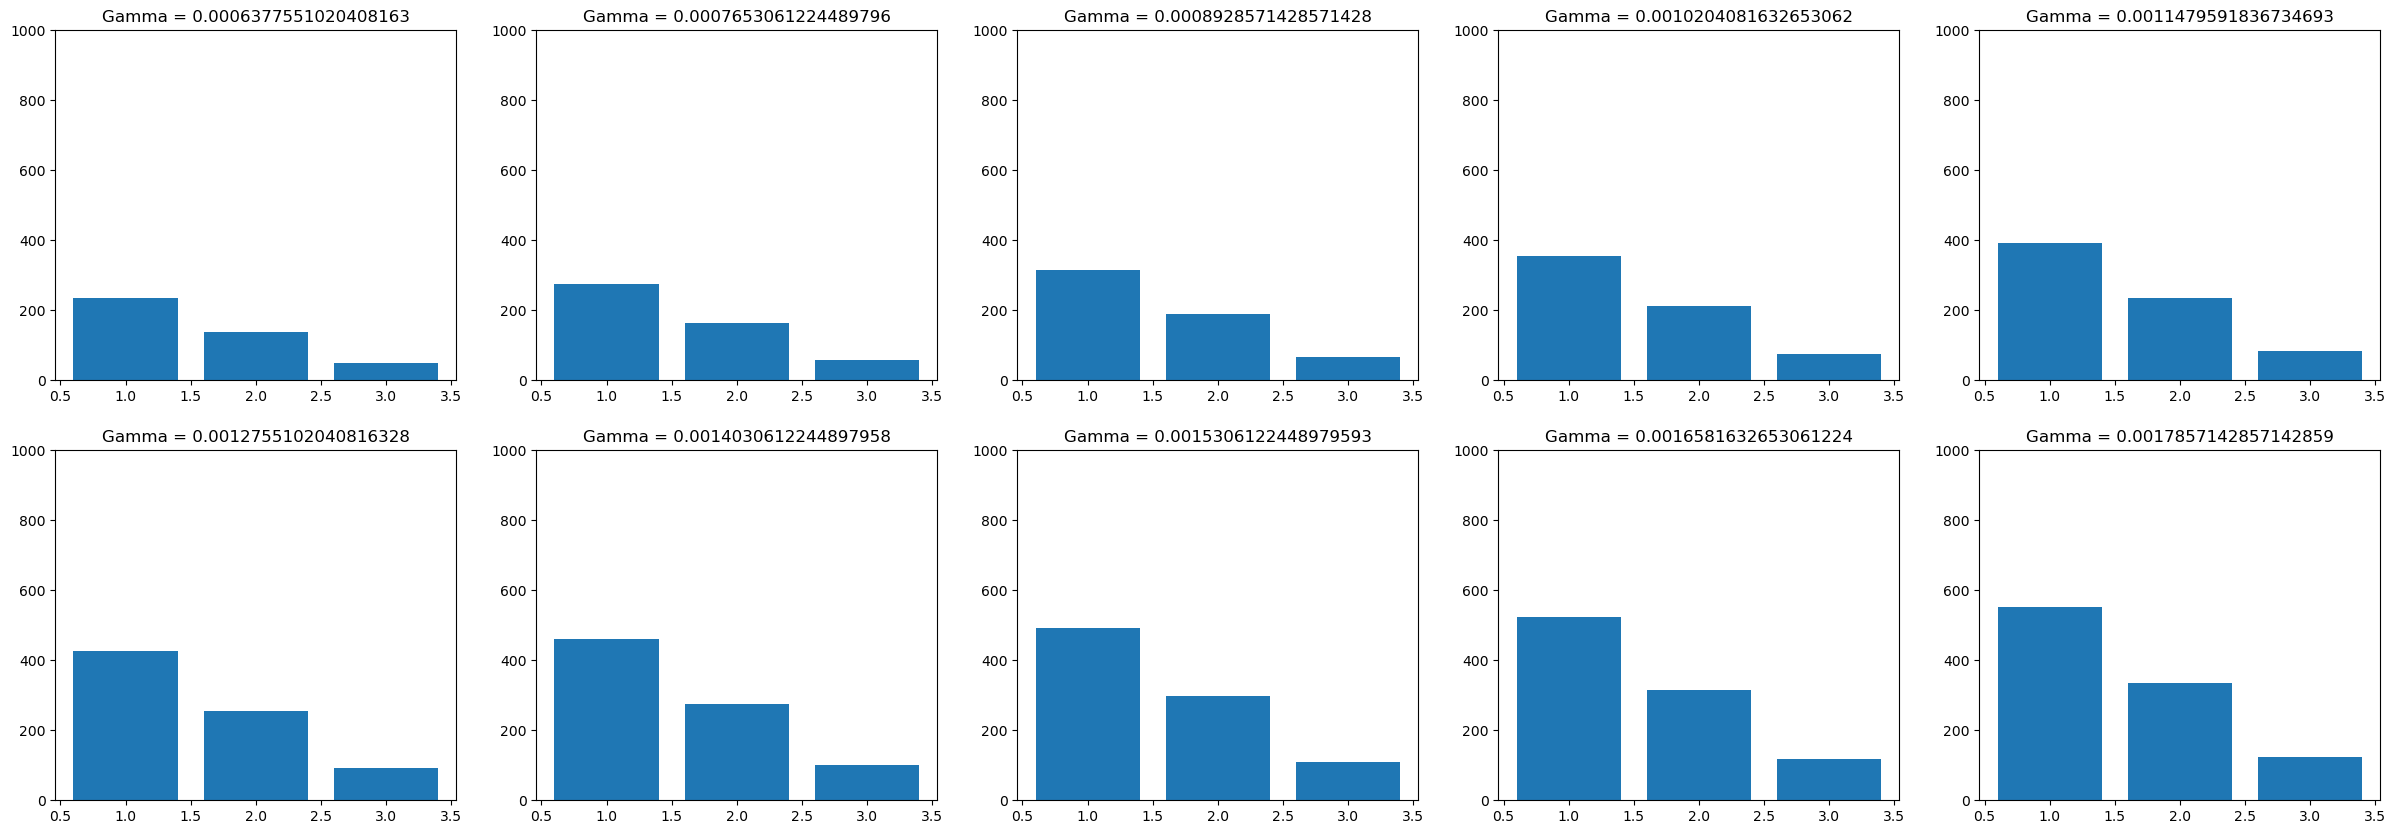

In [19]:
## Choose the range of the parameter gamma
gammas = np.arange(1/784 - 5 * (1/784) * (1/10), 1/784 + 5 * (1/784) * (1/10), (1/784) * (1/10))

## Extract eigenvalues
n_components = 3
eigenvalues_rbf = np.empty((len(gammas), n_components))

for i in range(len(gammas)):
    kernel_pca = KernelPCA(kernel="rbf", n_components = n_components, gamma = gammas[i])
    eigenvalues_rbf[i] = kernel_pca.fit(train_subset_scaled).eigenvalues_



fig, axs = plt.subplots(2, 5, figsize=(30, 10))
# Create 10 random plots
for i, ax in enumerate(axs.flat):
    x = np.arange(1, len(eigenvalues_rbf[i, :]) + 1, 1)
    # Plot the data on the corresponding axis
    ax.bar(x, eigenvalues_rbf[i, :])
    ax.set_ylim(0, 1000)
    # ax.set_xlabel('Component')
    # ax.set_ylabel('Eigenvalue')
    ax.set_title('Gamma = ' + str(gammas[i]))

### 1.3 Perform kPCA using another kernel

In [20]:
# Try kernel poly

kernel_pca = KernelPCA(kernel = "poly", n_components = 3)

data_pca_poly = kernel_pca.fit_transform(train_subset_scaled)

Text(0, 0.5, 'Principal Component 2')

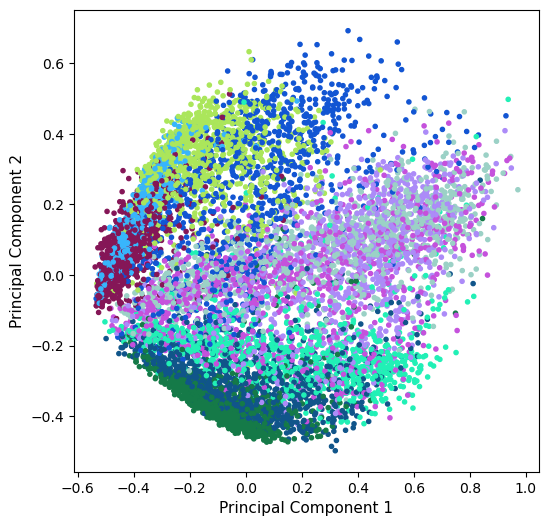

In [21]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], c = labels_train, marker='.', cmap = cmap)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# plt.savefig("Report/pca_poly_2comps.png")

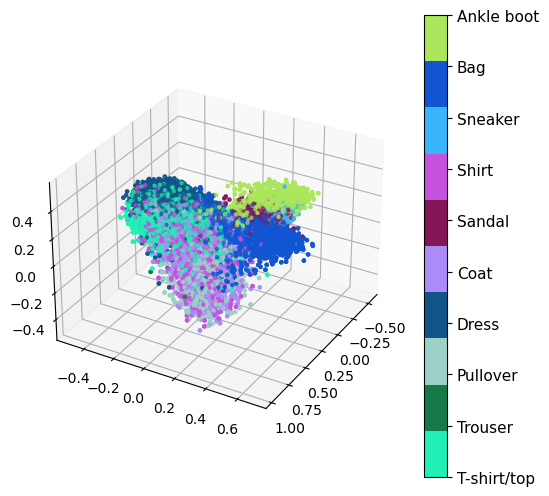

In [22]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], data_pca_poly[:, 2], c = labels_train, marker='.', cmap=cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)

ax.view_init(elev=30, azim=30)

# plt.savefig("Report/pca_poly_3comps.png")

In [23]:
# Try kernel sigmoid
kernel_pca = KernelPCA(kernel="sigmoid", n_components = 10)

data_pca_sigmoid = kernel_pca.fit_transform(train_subset_scaled)

eigenvalues_sigmoid = kernel_pca.eigenvalues_

Text(0, 0.5, 'Principal Component 2')

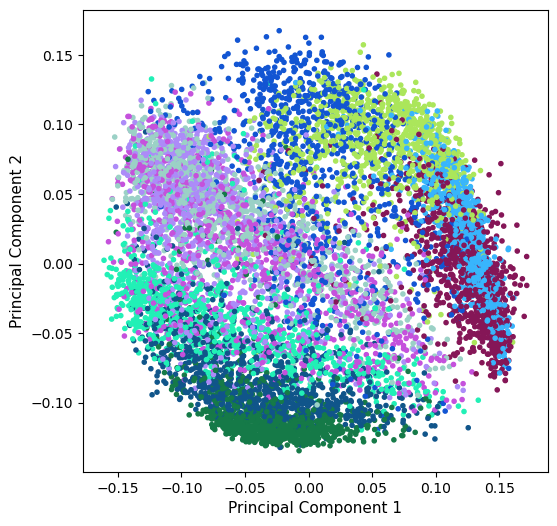

In [24]:
# Plot the first 2 principal components

fig = plt.figure(figsize=(6, 6))
p = plt.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels_train, marker='.', cmap = cmap)

# cb = plt.colorbar(p)
# cb.ax.set_title('Class', fontsize=11)
# del(cb)

plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)

# plt.savefig("Report/pca_sigmoid_2comps.png")

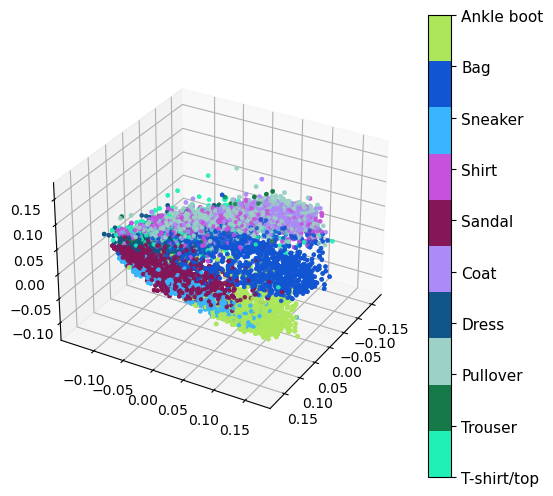

In [25]:
# Plot the first 3 principal components

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    p = ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], data_pca_sigmoid[:, 2], c = labels_train, marker='.', cmap = cmap)

cb = plt.colorbar(p, ax = ax, shrink = 1, aspect = 20)
cb.set_ticks(ticks)
cb.set_ticklabels(tick_labels, fontsize = 11)

ax.view_init(elev=30, azim=30)

# plt.savefig("Report/pca_sigmoid_3comps.png")

In [26]:
# Measure separation of the clusters using the Davies-Bouldin score
# The lower the better

# DB_score = []

# DB_score.append(davies_bouldin_score(data_pca_linear, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_rbf, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_poly, labels_train.reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels_train.reshape(-1)))

# print(f"DB score: linear: {DB_score[0]:.4f} | rbf: {DB_score[1]:.4f} | poly: {DB_score[2]:.4f} | sigmoid: {DB_score[3]:.4f}")

In [27]:
del(p)
del(axs)
del(ax)
del(fig)
del(cb)

## Exercise 2

In [28]:
# Perform clustering with different techniques

labels_Kmeans = KMeans(n_clusters = 10, n_init=10).fit(data_pca_sigmoid).labels_

labels_Spectral = SpectralClustering(n_clusters = 10, affinity='nearest_neighbors').fit(data_pca_sigmoid).labels_

labels_Gaussian = GaussianMixture(n_components = 10).fit(data_pca_sigmoid).predict(data_pca_sigmoid)

labels = np.array([labels_train.reshape(subset_size), labels_Kmeans, labels_Spectral, labels_Gaussian])

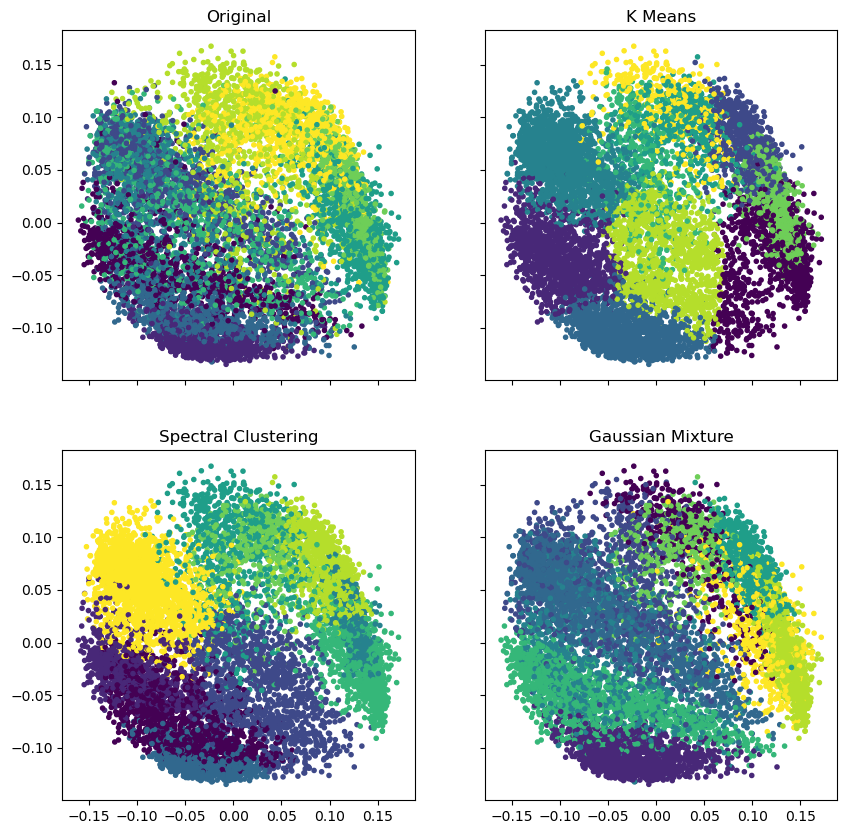

In [29]:
# Plot the results and compare them with the original clustering

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

title_names = ["Original", "K Means", "Spectral Clustering", "Gaussian Mixture"]

for ax, i in zip(axs.flat, range(4)):
    ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels[i, :], marker='.')
    ax.set_title(title_names[i])  
# plt.savefig("Report/unsupervised_clustering.png")

In [30]:
# Calculate Adjusted Rand Index

ARI = np.empty(3)

for i in range(3):
    ARI[i] = adjusted_rand_score(labels[0, :], labels[i + 1, :])
    print(f"Adjusted Rand Index for {title_names[i + 1]}: {ARI[i]:.4f}")


Adjusted Rand Index for K Means: 0.3611
Adjusted Rand Index for Spectral Clustering: 0.4340
Adjusted Rand Index for Gaussian Mixture: 0.3947


In [31]:
# Measure separation of the clusters using the Davies-Bouldin score
# The lower the better

# DB_score = []

# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[0, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[1, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[2, :].reshape(-1)))
# DB_score.append(davies_bouldin_score(data_pca_sigmoid, labels[3, :].reshape(-1)))

# print(f"DB score: original: {DB_score[0]:.4f} | KMeans: {DB_score[1]:.4f} | Spectral: {DB_score[2]:.4f} | Gaussian: {DB_score[3]:.4f}")

#### a
As we can see, label assignment performed poorly. This, probably, because the clusters are very close to each other and not clearly separated.

#### b
As we can see from the plot below, there is a clear elbow on the third component. This suggests that 10 does not reflect the actual knee point of the spectrum of the principal components.

Text(0, 0.5, 'Eigenvalue')

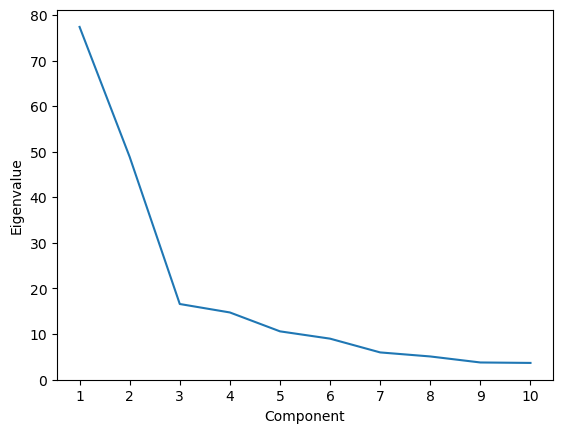

In [32]:
# Plot the eigenvalues obtained with the sigmoid method

plt.plot(np.arange(1, len(eigenvalues_sigmoid) + 1, 1), eigenvalues_sigmoid)

plt.xticks(np.arange(1, 11, 1))

plt.xlabel('Component')
plt.ylabel('Eigenvalue')

# plt.savefig("Report/eigenvalues_sigmoid.png")

In [33]:
del(ARI)
del(eigenvalues_sigmoid)
del(labels_Kmeans)
del(labels_Gaussian)
del(ax)
del(axs)
del(labels)

## Exercise 3

In [34]:
# Split the dataset into training and test set

x_train, x_test, y_train, y_test = train_test_split(train_subset_scaled, labels_Spectral, test_size=0.3, random_state=42)

#### 3.1: kernel SVM with different kernels

In [35]:
# Linear kernel

classifier = SVC(kernel = "linear").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_linear = classifier.predict(x_test)
acc_linear = accuracy_score(y_test, label_predict_SVC_linear)

acc_linear = accuracy_score(y_test, label_predict_SVC_linear)

In [36]:
# RBF kernel

classifier = SVC(kernel = "rbf").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_rbf = classifier.predict(x_test)
acc_rbf = accuracy_score(y_test, label_predict_SVC_rbf)

In [37]:
# Polynomial kernel

classifier = SVC(kernel = "poly").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_poly = classifier.predict(x_test)

acc_poly = accuracy_score(y_test, label_predict_SVC_rbf)

In [38]:
# Sigmoid kernel

classifier = SVC(kernel = "sigmoid").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_sigmoid = classifier.predict(x_test)

acc_sigmoid = accuracy_score(y_test, label_predict_SVC_sigmoid)

In [39]:
print(f"Accuracy: linear: {acc_linear:.2f} | rbf: {acc_rbf:.2f} | poly: {acc_poly:2f} | sigmoid: {acc_sigmoid:.2f}")

Accuracy: linear: 0.96 | rbf: 0.97 | poly: 0.973000 | sigmoid: 0.47


In [40]:
labels_SVC_unsupervised = np.concatenate((y_test.reshape(len(y_test), 1),
                                            label_predict_SVC_linear.reshape(len(y_test), 1),
                                            label_predict_SVC_rbf.reshape(len(y_test), 1),
                                            label_predict_SVC_poly.reshape(len(y_test), 1),
                                            label_predict_SVC_sigmoid.reshape(len(y_test), 1)), axis = 1)

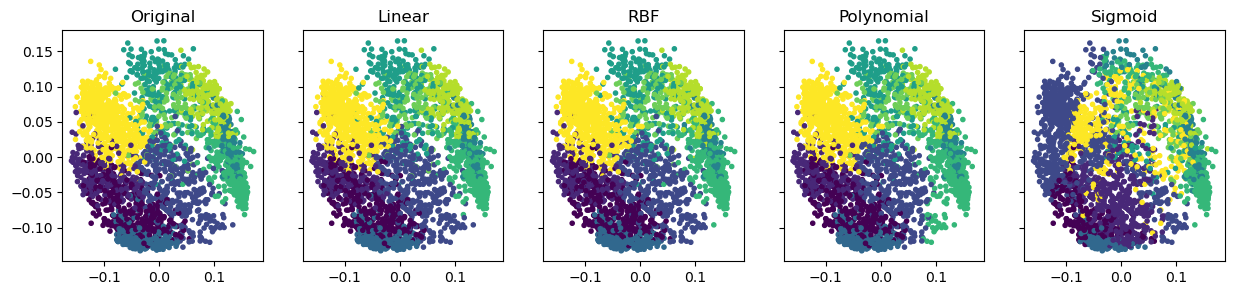

In [41]:
model = KernelPCA(kernel = "sigmoid", n_components = 3).fit_transform(x_test)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)

titles = ["Original", "Linear", "RBF", "Polynomial", "Sigmoid"]

i = 0
for ax in axs:
    ax.scatter(model[:, 0], model[:, 1], c = labels_SVC_unsupervised[:, i], cmap = 'viridis', marker='.')
    ax.title.set_text(titles[i])
    i += 1

#### 3.2: Fully Connected NN

In [42]:
## Pass data to tensors
data_train = TensorDataset(Tensor(x_train.reshape(-1, 1, 28, 28)), th.tensor(y_train, dtype = th.long))
data_train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = False)

data_test = TensorDataset(Tensor(x_test.reshape(-1, 1, 28, 28)), th.tensor(y_test, dtype = th.long))
data_test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE, shuffle = False)

In [43]:
# Decide if you want to train multiple models with different hyperparameters
train_multiple_models = False

In [44]:
# Define some functions needed to calculate the accuracy

def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [45]:
# Define function used to train the model

def train_model(epochs, train_loader, criterion, optimizer, device, model):
    _batch_losses = []
    
    _model = model
    for _ in trange(epochs):
        _model = _model.train()

        # Actual (batch-wise) training step
        for _, (_images, _labels) in enumerate(train_loader):
            _images = _images.to(device)
            _labels = _labels.to(device)

            _logits = _model(_images)
            _loss = criterion(_logits, _labels)
            _batch_losses.append(_loss.item())  # Store the loss for plotting, per batch

            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()
    
    return _model

In [46]:
## Define function used to get labels
def get_predicted_labels(model, test_data, device):
    test_data_tensor = th.tensor(test_data.reshape(-1, 1, 28, 28))

    model = model.eval()

    labels = []
    with th.no_grad():
        for i in range(test_data_tensor.shape[0]):
            data = test_data_tensor[i].reshape(1, 1, 28, 28)
            pred = model(data.to(device))
            labels.append(th.argmax(pred).item())
            
    return np.array(labels)

In [47]:
# Define the Fully Connected Neural Network

class FullyConnectedNN_1layer(nn.Module):
    def __init__(self, image_dim, n_classes):
        
        super(FullyConnectedNN_1layer, self).__init__()
        
        self.fc1 = nn.Linear(in_features = image_dim,
                            out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        # x = F.relu(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [48]:
# Choose device
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [49]:
# Train the model and calculate accuracy on the test set

if train_multiple_models:
    # Choose for which epochs to train the model
    epochs = np.arange(1, 21, 1)

    # Store the accuracies and predicted labels in two arrays
    trained_acc_FC_1l = []
    labels_FC_1l = np.ndarray((3000, len(epochs)))
    
    # Choose the loss  
    criterion = nn.CrossEntropyLoss()

    # Create a vectors to store the training time (column 1) for each epoch (column 0)
    times = np.ndarray((len(epochs), 2))

    for i in epochs:
        model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10).to(device)

        optimizer = th.optim.SGD(model.parameters(), lr=0.01)
        
        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)


        model = model.train()
        
        # Keep track of how much time is required to train the model
        start_time = time.time()
        model = train_model(epochs = i,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        end_time = time.time()
        
        times[i - 1, 0] = i
        times[i - 1, 1] = end_time - start_time
        
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_FC_1l.append(trained_acc)
        
        
        labels_FC_1l[:, i - 1] = get_predicted_labels(model = model, test_data = x_test, device = device)

        print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i - 1, 1]:.2f} s")


In [50]:
# Plot the accuracy as a function of the number of epochs

if train_multiple_models:
    plt.plot(np.arange(1, len(trained_acc_FC_1l) + 1, 1), trained_acc_FC_1l)
    plt.xticks(np.arange(1, len(trained_acc_FC_1l) + 1, 2))
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex3_FCNN1l_accuracy-epochs.png")

In [51]:
# Try with two layers
class FullyConnectedNN_2layer(nn.Module):
    def __init__(self, image_dim, n_classes, hidden_features):
        
        super(FullyConnectedNN_2layer, self).__init__()
        
        self.fc1 = nn.Linear(in_features = image_dim,
                            out_features = hidden_features)
        
        self.fc2 = nn.Linear(in_features = hidden_features,
                             out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        # x = F.relu(x)
        x = self.fc2(x)
        # x = F.relu(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [52]:
# See how accuracy vary with the number of hidden neurons

if train_multiple_models:
    # Choose for which numbers of neurons to train the model
    neurons = np.arange(50, 10050, 100)

    trained_acc_FC_2l_neurons = []
    labels_FC_2l = np.ndarray((len(x_test), len(neurons)))

    times = np.ndarray((len(neurons), 2))

    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    for i in range(len(neurons)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = neurons[i])
        
        model = model.to(device)
        print(f"Using device: {device}")

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        model = model.eval()
        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)
        model = model.train()
        start_time = time.time()
        model = train_model(epochs = 8,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        
        times[i, 0] = neurons[i]
        times[i, 1] = time.time() - start_time
        
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_FC_2l_neurons.append(trained_acc)
        
        print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        model = model.eval()
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device=device, model = model)

In [53]:
# Plot accuracy wrt number of neurons

if train_multiple_models:
    plt.plot(np.arange(50, 50 + 100 * len(trained_acc_FC_2l_neurons), 100), trained_acc_FC_2l_neurons)
    plt.ylim((50, 100))
    plt.xlabel("Number of hidden neurons")
    plt.ylabel("Accuracy")

    # plt.savefig("Report/ex3_FCNN2l_accuracy-neurons.png")

In [54]:
# Test how accuracy varies depending on the number of epochs

if train_multiple_models:
    # Define vector to keep all the accuracies, that we will plot
    trained_acc_FC_2l = []

    # Define an array to keep all the predicted labels
    labels_FC_2l = np.ndarray((len(x_test), len(epochs)))

    # Choose loss
    criterion = nn.CrossEntropyLoss()

    times = np.ndarray((len(epochs), 2))


    for i in range(len(epochs)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 850)
        
        model = model.to(device)
        print(f"Using device: {device}")

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)

        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
        
        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        
        times[i, 0] = epochs[i]
        times[i, 1] = time.time() - start_time
        
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_FC_2l.append(trained_acc)
        
        print(f"Epochs: {i} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        model = model.eval()
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device=device, model = model)

In [55]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(np.arange(1, 21, 1), trained_acc_FC_2l)
    plt.xticks(np.arange(1, 21, 2))
    plt.ylim((50, 100))
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")

    # plt.savefig("Report/ex3_FCNN2l_accuracy-epochs.png")

In [56]:
# Choose one model and a set of parameter to predict the labels

times = []
fcnn_test_accuracies = []

for i in range(10):
    model = FullyConnectedNN_2layer(
        image_dim=28 * 28, n_classes=10, hidden_features=4000
    )

    model = model.to(device)

    optimizer = th.optim.SGD(model.parameters(), lr=0.01)

    criterion = nn.CrossEntropyLoss()

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(
        model, criterion, data_train_loader, device
    )

    model = model.train()

    start_time = time.time()
    model = train_model(
        epochs=9,
        train_loader=data_train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        model=model,
    )

    elapsed_time = time.time() - start_time

    model = model.eval()

    trained_loss, trained_acc = get_test_stats(
        model, criterion, data_test_loader, device
    )

    print(
        f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s"
    )
    times.append(elapsed_time)
    fcnn_test_accuracies.append(trained_acc)

model = model.eval()
labels_FCNN = get_predicted_labels(test_data=x_test, device=device, model=model)

 11%|█         | 1/9 [00:00<00:07,  1.07it/s]

100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Accuracy: untrained: 3.1250 | Trained: 87.5000 | Time: 7.56 s


100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


Accuracy: untrained: 7.8125 | Trained: 87.5000 | Time: 7.31 s


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Accuracy: untrained: 17.1875 | Trained: 87.5000 | Time: 7.43 s


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Accuracy: untrained: 12.5000 | Trained: 85.9375 | Time: 7.63 s


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Accuracy: untrained: 14.0625 | Trained: 87.5000 | Time: 9.15 s


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Accuracy: untrained: 14.0625 | Trained: 87.5000 | Time: 8.86 s


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Accuracy: untrained: 9.3750 | Trained: 85.9375 | Time: 7.43 s


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Accuracy: untrained: 20.3125 | Trained: 85.9375 | Time: 7.66 s


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Accuracy: untrained: 6.2500 | Trained: 87.5000 | Time: 7.53 s


100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Accuracy: untrained: 7.8125 | Trained: 87.5000 | Time: 6.92 s


In [57]:
print(
    f"Average time: {np.mean(times):.2f} s | Max time: {np.max(times):.2f} s | Min time: {np.min(times):.2f} s"
)
print(
    f"Average accuracy: {np.mean(fcnn_test_accuracies):.2f}% | Max accuracy: {np.max(fcnn_test_accuracies):.2f}% | Min accuracy: {np.min(fcnn_test_accuracies):.2f}%"
)

Average time: 7.75 s | Max time: 9.15 s | Min time: 6.92 s
Average accuracy: 87.03% | Max accuracy: 87.50% | Min accuracy: 85.94%


#### 3.3: Convolutional Neural Network

In [58]:
class CNN_1layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size):
        super(CNN_1layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = self._dimensions[1],
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(self._dimensions[1])
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        
        self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool(x)

        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        
        x = F.log_softmax(x, dim = 1)
        
        return x

In [59]:
# Train the model for different number of epochs

if train_multiple_models:
    model = CNN_1layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28])

    # Choose loss
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)
    # Define vector to keep all the accuracies, that we will plot
    trained_acc_CNN_1l = []

    epochs = [1, 10, 20]

    CNN_labels = np.ndarray((len(x_test), len(epochs)))

    times = np.ndarray((len(epochs), 2))

    for i in range(len(epochs)):

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)


        model = model.to(device)

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        
        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        
        times[i - 1, 0] = epochs[i]
        times[i - 1, 1] = time.time() - start_time
            
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        trained_acc_CNN_1l.append(trained_acc)

        model = model.eval()

        CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [60]:
# Plot the accuracy wrt the number of epochs used to train the model
if train_multiple_models:
    plt.plot(epochs, trained_acc_CNN_1l)
    plt.xticks(epochs)
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex3_CNN1l_accuracy-epochs.png")

In [61]:
# Try with two layers

class CNN_2layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size, hidden_size):
        super(CNN_2layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = hidden_size,
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(hidden_size)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool1 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self._dimensions[1], kernel_size=self._kernel)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        self.bn2 = nn.BatchNorm2d(self._dimensions[1])
        
        self.pool2 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        self.fc1 = nn.Linear(in_features = int(self._dimensions[2] * self._dimensions[3]), out_features = self._n_classes)
    
        
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        
        x = F.relu(x)
        
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)

        x = F.log_softmax(x, dim = 1)

        return x

In [62]:
# Train the model for different number of epochs`

if train_multiple_models:
    model = CNN_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size=100)

    criterion = nn.CrossEntropyLoss()

    trained_acc_CNN_2l = []

    CNN_labels = np.ndarray((len(x_test), len(epochs)))

    times = np.ndarray((len(epochs), 2))

    for i in range(len(epochs)):

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)


        model = model.to(device)
        print(f"Using device: {device}")

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

        model = model.train()
        
        start_time = time.time()
        model = train_model(epochs = epochs[i],
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        times[i, 0] = epochs[i]
        times[i, 1] = time.time() - start_time
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()

        CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [63]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(epochs, trained_acc_CNN_2l)
    plt.xticks(epochs)
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex3_CNN2l_accuracy-epochs.png")

In [64]:
# Train the model for different number of neurons

if train_multiple_models:
    criterion = nn.CrossEntropyLoss()

    trained_acc_CNN_2l = []

    neurons = [50, 500, 1000]

    times = np.ndarray((len(neurons), 2))

    CNN_labels = np.ndarray((len(x_test), len(neurons)))

    for i in range(len(neurons)):
        model = CNN_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size = neurons[i])
        
        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        
        model = model.to(device)
        print(f"Using device: {device}")

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

        model = model.train()
        start_time = time.time()
        model = train_model(epochs = 2,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)
        times[i, 0] = neurons[i]
        times[i, 1] = time.time() - start_time
        model = model.eval()

        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()

        CNN_labels[:, i] = get_predicted_labels(model = model, test_data = x_test, device = device)

In [65]:
# Plot the accuracy wrt the number of neurons per hidden layer
if train_multiple_models:
    plt.plot(neurons, trained_acc_CNN_2l)
    plt.xticks(neurons)
    plt.xlabel('Number of neurons per hidden layer')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex3_CNN2l_accuracy-neurons.png")

In [67]:
# Choose one model and a set of parameter to predict the labels
times = []
cnn_test_accuracies = []

for i in range(10):
    model = CNN_2layer(
        n_classes=10, kernel_size=3, input_size=[7000, 1, 28, 28], hidden_size=50
    )

    model = model.to(device)

    optimizer = th.optim.SGD(model.parameters(), lr=0.01)

    criterion = nn.CrossEntropyLoss()

    model = model.eval()

    untrained_loss, untrained_acc = get_test_stats(
        model, criterion, data_train_loader, device
    )

    model = model.train()

    start_time = time.time()
    model = train_model(
        epochs=5,
        train_loader=data_train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        model=model,
    )

    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

    model = model.eval()

    trained_loss, trained_acc = get_test_stats(
        model, criterion, data_test_loader, device
    )
    cnn_test_accuracies.append(trained_acc)

    print(
        f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s"
    )

model = model.eval()
labels_CNN = get_predicted_labels(test_data=x_test, device=device, model=model)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


Accuracy: untrained: 12.5000 | Trained: 90.6250 | Time: 19.52 s


100%|██████████| 5/5 [00:19<00:00,  3.91s/it]


Accuracy: untrained: 4.6875 | Trained: 87.5000 | Time: 19.56 s


100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


Accuracy: untrained: 7.8125 | Trained: 89.0625 | Time: 18.21 s


100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


Accuracy: untrained: 9.3750 | Trained: 76.5625 | Time: 17.15 s


100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


Accuracy: untrained: 15.6250 | Trained: 84.3750 | Time: 17.97 s


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Accuracy: untrained: 25.0000 | Trained: 92.1875 | Time: 18.18 s


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Accuracy: untrained: 9.3750 | Trained: 85.9375 | Time: 18.72 s


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Accuracy: untrained: 12.5000 | Trained: 87.5000 | Time: 20.42 s


100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


Accuracy: untrained: 15.6250 | Trained: 89.0625 | Time: 19.63 s


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


Accuracy: untrained: 6.2500 | Trained: 87.5000 | Time: 19.26 s


In [69]:
print(
    f"Average time: {np.mean(times):.2f} s | Max time: {np.max(times):.2f} s | Min time: {np.min(times):.2f} s"
)
print(
    f"Average accuracy: {np.mean(cnn_test_accuracies):.2f}% | Max accuracy: {np.max(cnn_test_accuracies):.2f}% | Min accuracy: {np.min(cnn_test_accuracies):.2f}%"
)

Average time: 18.86 s | Max time: 20.42 s | Min time: 17.15 s
Average accuracy: 87.03% | Max accuracy: 92.19% | Min accuracy: 76.56%


In [70]:
# Define a 2-layer Fully Convolutional Network

class FullyConv_2layer(nn.Module):
    def __init__(self, n_classes, kernel_size, input_size, hidden_size):
        super(FullyConv_2layer, self).__init__()
        
        self._n_classes = n_classes
        
        self._padding = 0 # Default value
        
        self._stride = 1 # Default value
        
        self._stride_inv = 1 / self._stride
        
        self._kernel = kernel_size
        
        self._dimensions = input_size
        
 
        self.conv1 = nn.Conv2d(in_channels=self._dimensions[1],
                               out_channels = hidden_size,
                               kernel_size=self._kernel)
        
        self.bn1 = nn.BatchNorm2d(hidden_size)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
            
        self.pool1 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
        
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=self._dimensions[1], kernel_size=self._kernel)
        
        self._dimensions = [self._dimensions[0],
                            self._dimensions[1] ,
                            (self._dimensions[2] - self._kernel + 2 * self._padding) * self._stride_inv + 1,
                            (self._dimensions[3] - self._kernel + 2 * self._padding) * self._stride_inv + 1
                            ]
        
        self.bn2 = nn.BatchNorm2d(self._dimensions[1])
        
        self.pool2 = nn.MaxPool2d(2, stride = self._stride)
        
        self._dimensions = [self._dimensions[0],
                                self._dimensions[1] ,
                                (self._dimensions[2] - 2) * self._stride_inv + 1,
                                (self._dimensions[3] - 2) * self._stride_inv + 1
                                ]
    
        
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.bn1(x)
        
        x = F.relu(x)
        
        x = self.pool1(x)
        
        x = self.conv2(x)
        
        x = self.bn2(x)
        
        x = F.relu(x)
        
        x = self.pool2(x)
        
        x = x.view(x.shape[0], -1)

        x = F.log_softmax(x, dim = 1)

        return x

In [71]:
model = FullyConv_2layer(n_classes = 10, kernel_size = 3, input_size=[7000, 1, 28, 28], hidden_size = 250)

optimizer = th.optim.SGD(model.parameters(), lr = 0.01)


model = model.to(device)
print(f"Using device: {device}")

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

model = model.train()
start_time = time.time()
model = train_model(epochs = 2,
                    train_loader = data_train_loader,
                    criterion = criterion,
                    optimizer = optimizer,
                    device = device,
                    model = model)
elapsed_time = time.time() - start_time
model = model.eval()

trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
print(f"Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {elapsed_time:.2f} s")

Using device: cpu
Untrained test loss: 6.1547, accuracy: 1.56%


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:35<00:00, 17.59s/it]

Accuracy: untrained: 1.5625 | Trained: 6.2500 | Time: 35.17 s


### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

In [72]:
print(train_subset_scaled.shape)
print(data_pca_sigmoid.shape)
print(label_predict_SVC_linear.shape)
print(label_predict_SVC_sigmoid.shape)
print(label_predict_SVC_rbf.shape)
print(labels_FCNN.shape)
print(labels_CNN.shape)

(10000, 784)
(10000, 10)
(3000,)
(3000,)
(3000,)
(3000,)
(3000,)


Creating training and testing datasets. Also printing an image and its label. This is to remind us that the labels are given by the Spectral clustering and therefore can be wrong. 

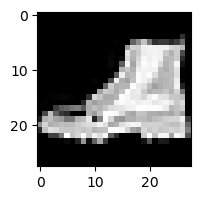

Bag
(7000, 784)
(10000, 784)


In [199]:
# Here the labels are taken from the Spectral clustering!!

x_train, x_test, y_train, y_test = train_test_split(
    train_subset_scaled, labels_Spectral, test_size=0.3, random_state=42
)

idx = 12

plt.figure(figsize=(2, 2))
plt.imshow(x_test[idx].reshape(28, 28), cmap="gray")

plt.show()

print(description[y_test[idx].item()])
print(x_train.shape)
print(train_subset_scaled.shape)

In [194]:
def print_img_index(indices, img_set, lab_set, class_number):
    counter = np.zeros(10)

    # Counting number of appearance of each label
    for i in range(len(indices)):
        label = lab_set[indices[i]]
        counter[label] += 1

    # Plotting the images with the labels as titles
    fig, axs = plt.subplots(5, 6, figsize=(10, 10))
    axs = axs.flatten()

    for i, idx in enumerate(indices):
        axs[i].imshow(
            img_set[idx].reshape(28, 28), cmap="gray"
        )  # Assuming images are 28x28 pixels
        axs[i].axis("off")  # Turn off axis labels for cleaner visualization
        # string = str(description[labels_subset[idx]])
        axs[i].set_title(description[lab_set[idx].item()])

    fig.suptitle(f"Class {class_number}")

    # Printing the counted amounts
    # for j in range(10):
    #     print(f"{description[j]}: {counter[j]}")

In [195]:
# Gets 30 samples for the specified class according to given labels
def show_class(class_number, learnt_labels, true_labels):
    indices = []
    counter = np.zeros(10)
    idx = np.random.choice(len(learnt_labels), size=1, replace=False)[0]
    for i in range(30):
        idx = np.random.choice(len(learnt_labels), size=1, replace=False)[0]
        while learnt_labels[idx] != class_number:
            idx = np.random.choice(len(learnt_labels), size=1, replace=False)[0]
            
        indices.append(idx)
        counter[true_labels[idx]] += 1

    print_img_index(indices, x_test, true_labels, class_number)

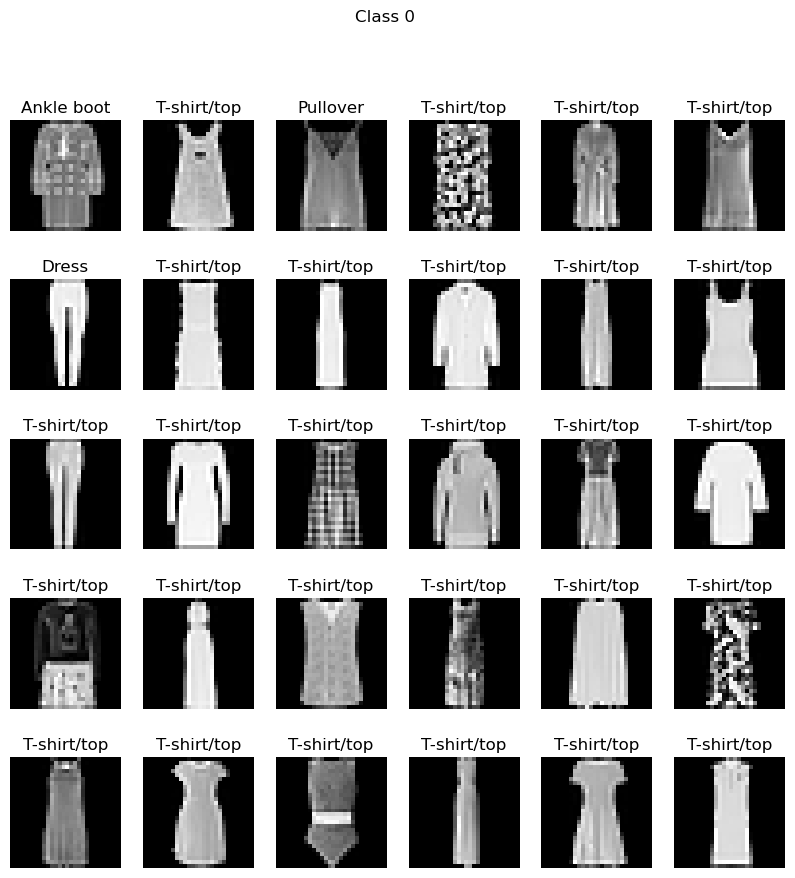

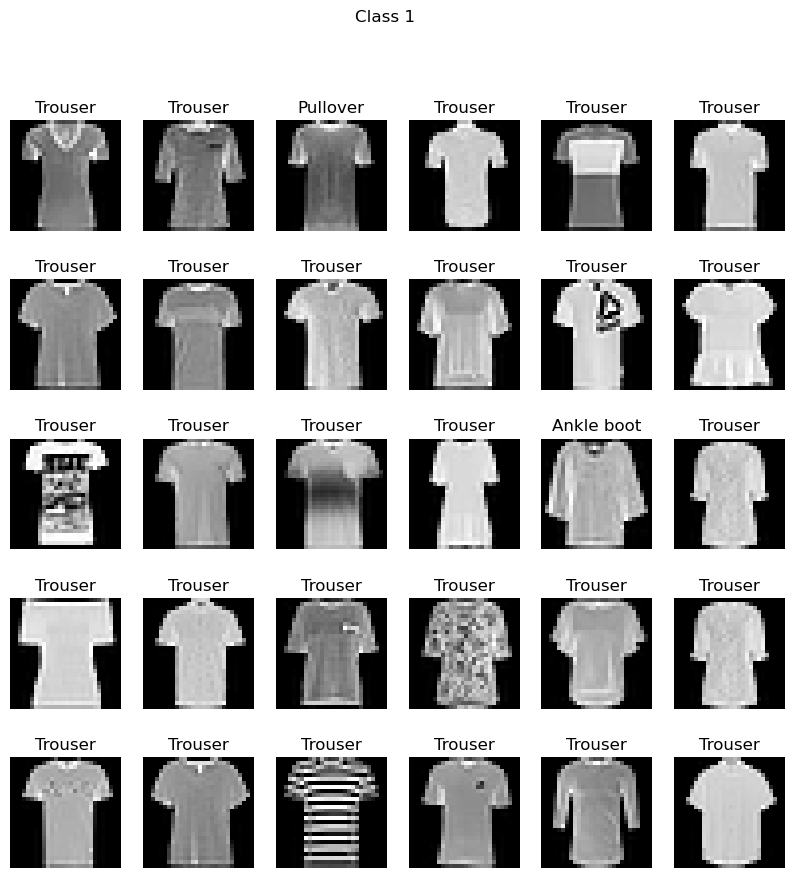

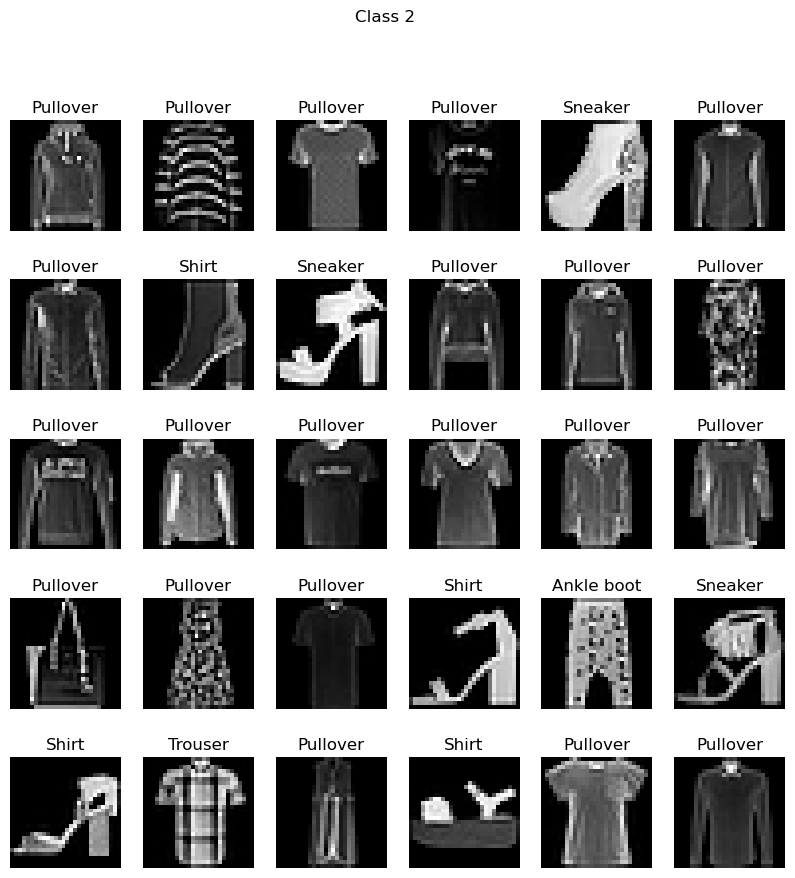

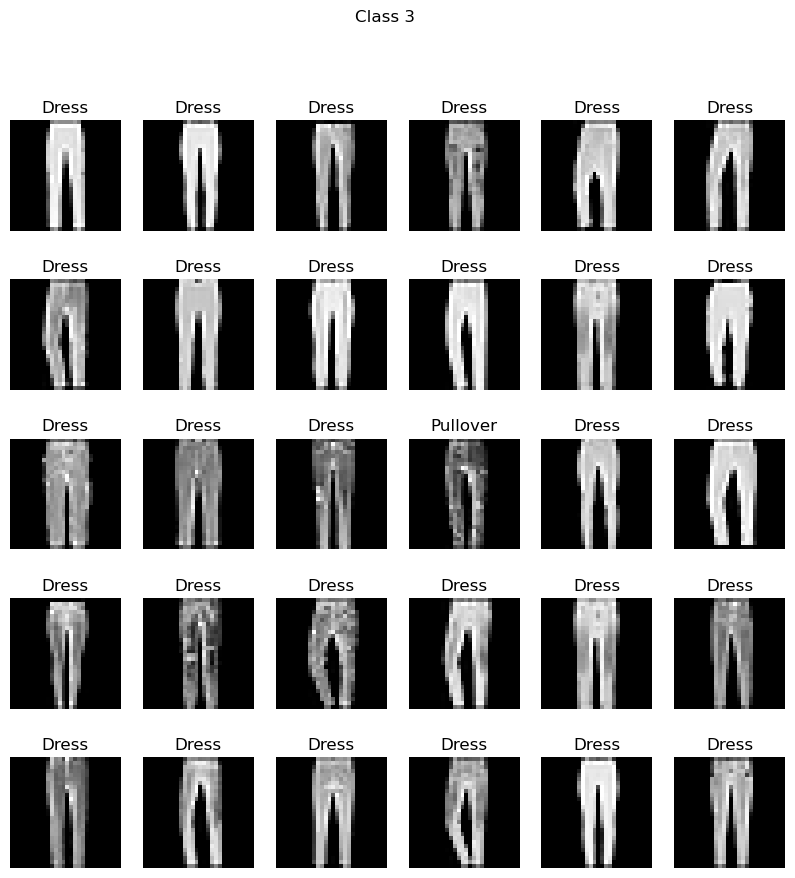

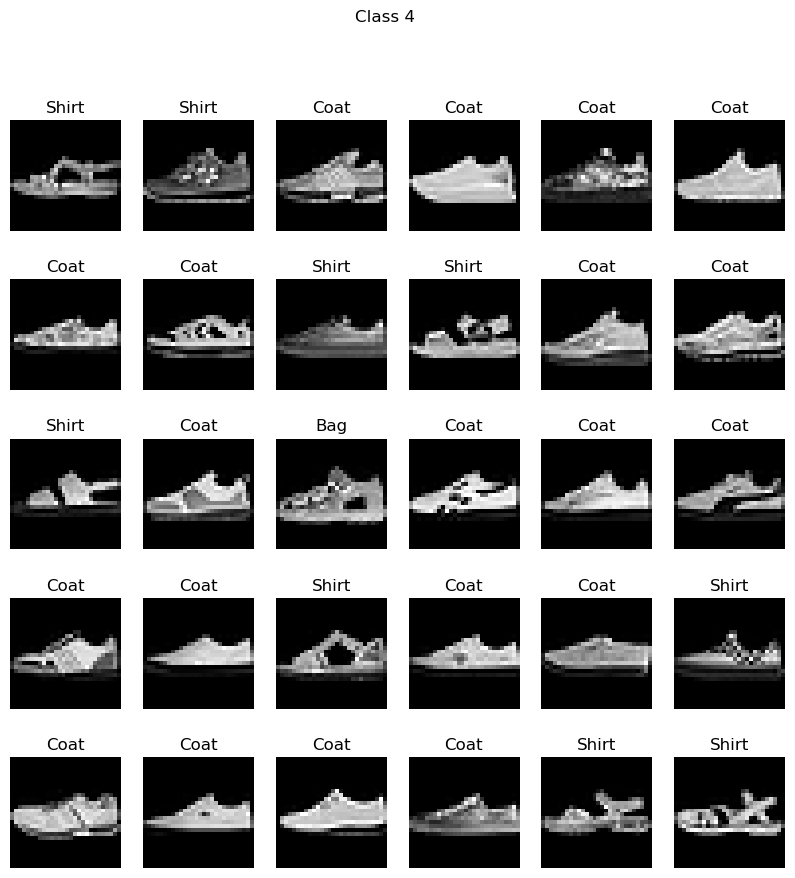

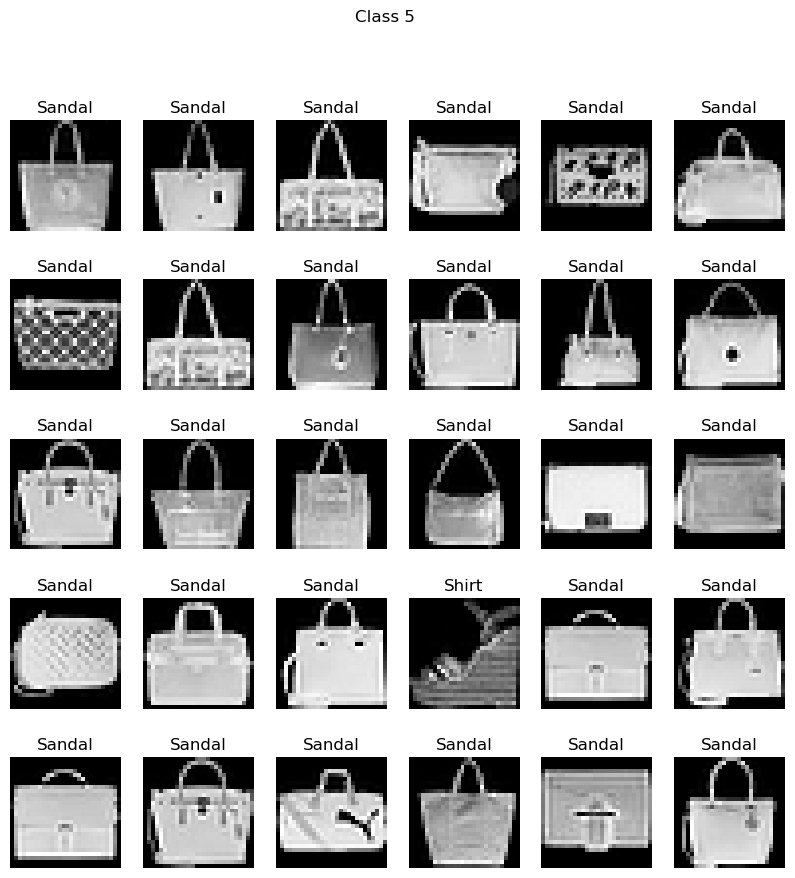

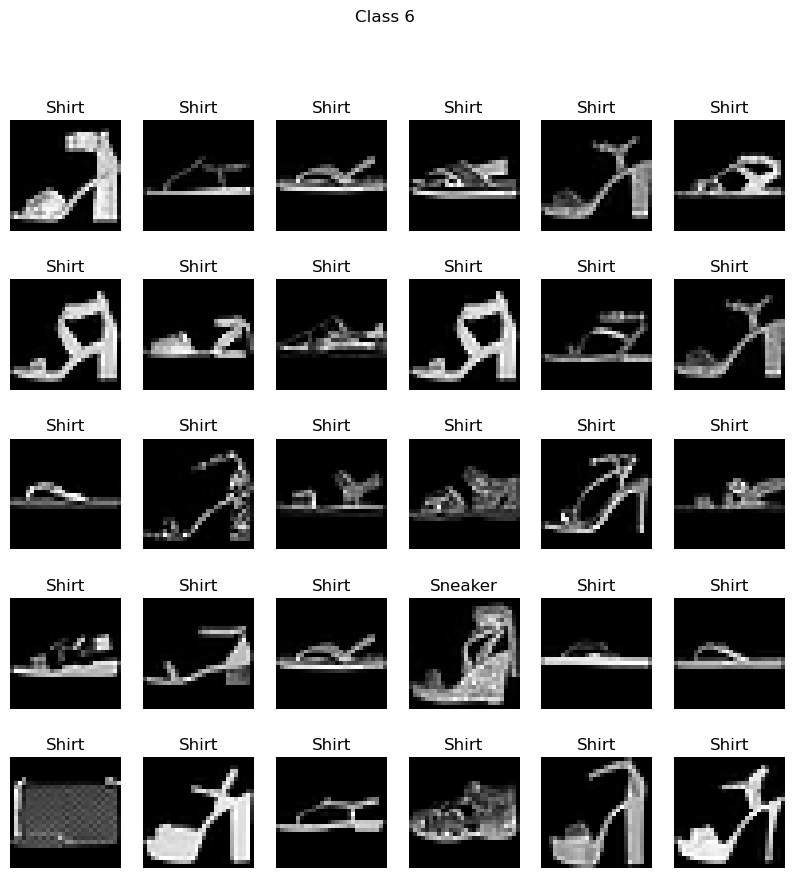

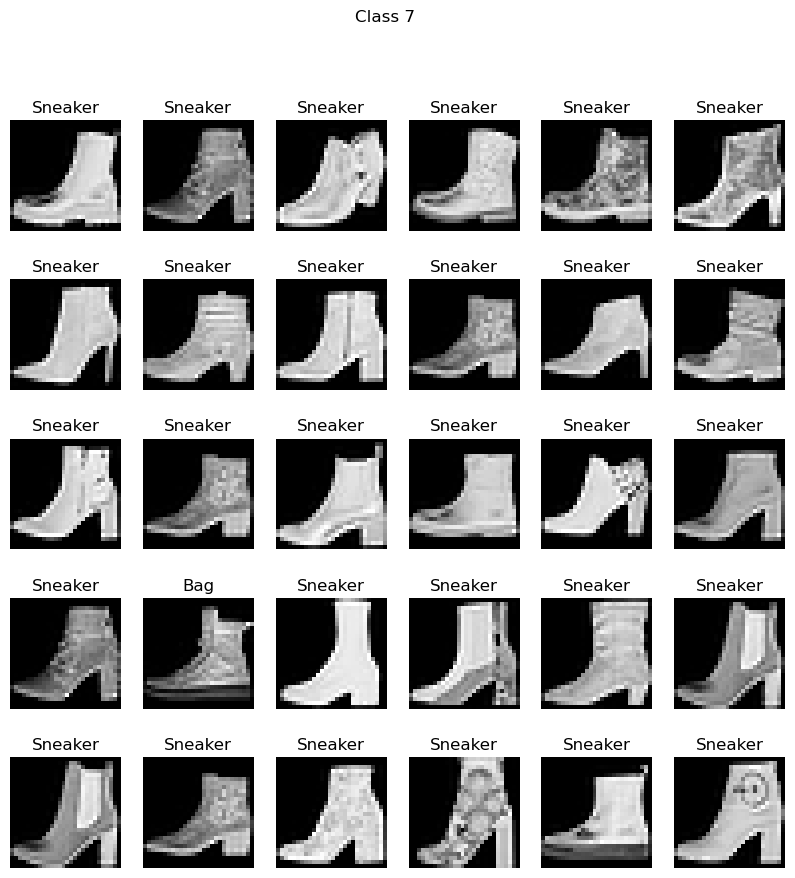

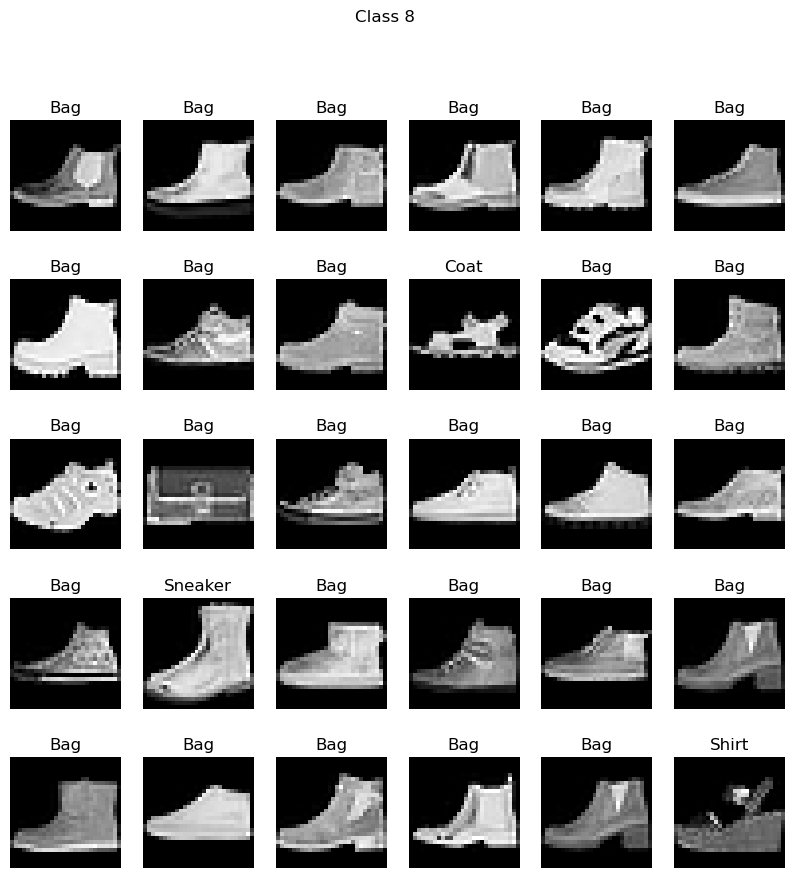

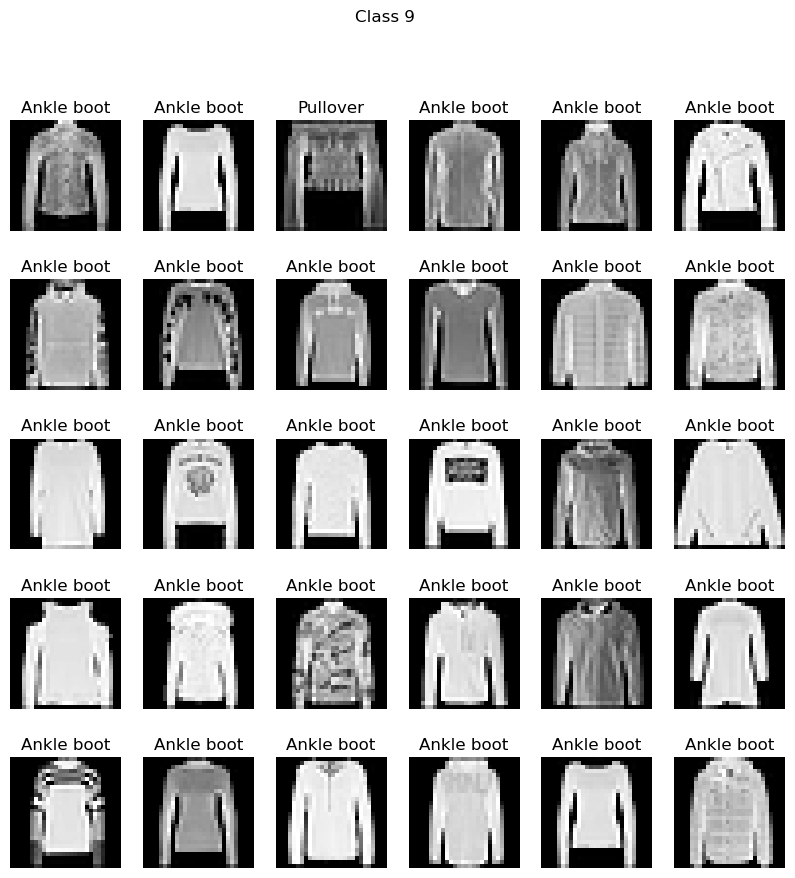

In [196]:
for i in range(10):
    show_class(i, labels_CNN, y_test)

[96.47 97.3  97.3  46.63 87.5  92.19]
          methods  accuracies
1         SVC rbf       97.30
2  SVC polynomial       97.30
0      SVC linear       96.47
5             CNN       92.19
4            FCNN       87.50
3     SVC sigmoid       46.63


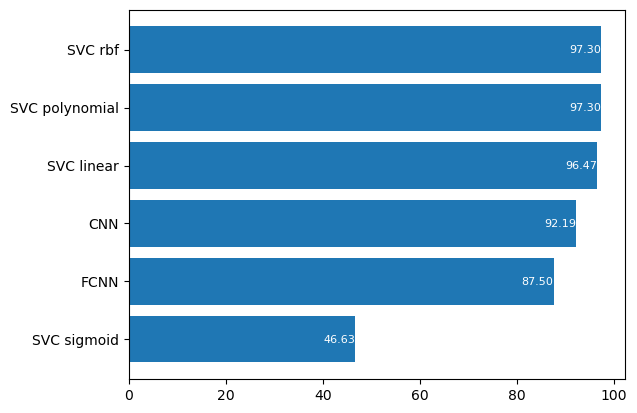

In [134]:
# Horizontal bar chart
import pandas as pd

fig, ax = plt.subplots()
methods = ["SVC linear", "SVC rbf", "SVC polynomial", "SVC sigmoid", "FCNN", "CNN"]
accuracies = np.round([100*acc_linear, 100*acc_rbf, 100*acc_poly, 100*acc_sigmoid, np.max(fcnn_test_accuracies), np.max(cnn_test_accuracies)], 2)
print(accuracies)
df = pd.DataFrame({"methods": methods, "accuracies": accuracies})
df.sort_values("accuracies", inplace=True, ascending=False)

print(df)

bars = ax.barh(y=df.methods, width=df.accuracies)
ax.set_yticks(np.arange(len(df.methods)))
ax.invert_yaxis()
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             va='center', ha='right', fontsize=8, color = 'white')

plt.show()

### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [ ]:
# Split train and test dataset as before, but this time use the true labels

x_train, x_test, y_train, y_test = train_test_split(train_subset_scaled, labels_train, test_size = 0.3, random_state = 42)

In [ ]:
classifier = SVC(kernel = "linear").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_linear = classifier.predict(x_test)

In [ ]:
classifier = SVC(kernel = "rbf").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_rbf = classifier.predict(x_test)

In [ ]:
classifier = SVC(kernel = "poly").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_poly = classifier.predict(x_test)

In [ ]:
classifier = SVC(kernel = "sigmoid").fit(x_train, y_train.reshape(len(y_train)))

label_predict_SVC_sigmoid = classifier.predict(x_test)

In [ ]:
print(f"Accuracy: Linear {accuracy_score(y_test, label_predict_SVC_linear):.2} | RBF {accuracy_score(y_test, label_predict_SVC_rbf):.2} | Poly {accuracy_score(y_test, label_predict_SVC_poly):.2} |Sigmoid {accuracy_score(y_test, label_predict_SVC_sigmoid):.2}")

In [ ]:
labels_SVC_true = np.concatenate((y_test.reshape(len(y_test), 1),
                             label_predict_SVC_linear.reshape(len(label_predict_SVC_linear), 1),
                             label_predict_SVC_rbf.reshape(len(label_predict_SVC_rbf), 1),
                             label_predict_SVC_poly.reshape(len(label_predict_SVC_poly), 1),
                             label_predict_SVC_sigmoid.reshape(len(label_predict_SVC_sigmoid), 1)), axis = 1)

In [ ]:
model = KernelPCA(n_components = 2, kernel = "sigmoid").fit_transform(x_test)

fig, axs = plt.subplots(1, 5, figsize = (15, 3), sharex=True, sharey=True)

titles = ["True labels", "Linear kernel", "RBF kernel", "Polynomial kernel", "Sigmoid kernel"]

i = 0
for ax in axs:
    ax.scatter(model[:, 0], model[:, 1], c = labels_SVC_true[:, i], cmap = 'viridis')
    ax.title.set_text(titles[i])
    i += 1



In [ ]:
labels = np.hstack((labels_SVC_unsupervised, labels_SVC_true))

In [ ]:
i = 0
title = ["Unsupervised"]
fig, axs = plt.subplots(3, 3, figsize = (9, 9), sharex=True, sharey=True)
for ax in axs:
    if i == 0 or i == 5:
        continue
    else:
        ax.scatter(model[:, 0], model[:, 1], c = labels[:, i], cmap = 'viridis')
        ax.title.set_text(titles[i])
        i += 1

#### 5.2: Fully Connected NN
Trying different numbers of layers and hidden features

In [ ]:
data_train = TensorDataset(Tensor(x_train.reshape(-1, 1, 28, 28)), th.tensor(y_train.reshape(len(y_train)), dtype = th.long))
data_train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = False)

data_test = TensorDataset(Tensor(x_test.reshape(-1, 1, 28, 28)), th.tensor(y_test.reshape(len(y_test)), dtype = th.long))
data_test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

### 5.2
Fully Connected Neural Network

In [ ]:
# Train the Fully Connected Neural Network with 1 layer and calculate accuracy on the test set for different number of epochs

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

    model = model.eval()

    model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10).to(device)


    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    epochs = np.arange(1, 21, 1)

    trained_acc_FC_1l = []
    labels_FC_1l = np.ndarray((len(x_test), len(epochs)))

    for i in range(len(epochs)):
        
        model = FullyConnectedNN_1layer(image_dim = 28 * 28, n_classes = 10).to(device)

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        
        model = model.train()

        model = train_model(epochs = epochs[i],
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_1l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_1l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(epochs, trained_acc_FC_1l)
    plt.xticks(epochs[::2])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_FCNN1l_accuracy-epochs.png")

In [ ]:
# Train the Fully Connected Neural Network with 2 layers and calculate accuracy on the test set for different number of epochs

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

    model = model.eval()

    model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features=250).to(device)


    untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
    print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

    trained_acc_FC_2l = []
    labels_FC_2l = np.ndarray((len(x_test), len(epochs)))

    for i in range(len(epochs)):
        
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features=250).to(device)

        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)
        
        model = model.train()

        model = train_model(epochs = epochs[i],
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_2l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model

if train_multiple_models:
    plt.plot(epochs, trained_acc_FC_2l)
    plt.xticks(epochs[::2])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_FCNN2l_accuracy-epochs.png")

In [ ]:
# Train the Convolutional Neural Network with 2 layers and calculate accuracy on the test set for different number of neurons

if train_multiple_models:
    # Choose the loss
    criterion = nn.CrossEntropyLoss()

    neurons = np.arange(50, 10050, 100)

    labels_FC_2l = np.ndarray((len(x_test), len(neurons)))
    trained_acc_FC_2l = []


    for i in range(len(neurons)):
        model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = neurons[i]).to(device)
        optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")
        
        model = model.train()

        model = train_model(epochs = 2,
                                train_loader = data_train_loader,
                                criterion = criterion,
                                optimizer = optimizer,
                                device = device,
                                model = model)
        model = model.eval()
                
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        
        trained_acc_FC_2l.append(trained_acc)

        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")
        
        labels_FC_2l[:, i] = get_predicted_labels(test_data = x_test, device = device, model = model)

    # print(f"Epochs: {epochs[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times[i, 1]:.2f} s")

In [ ]:
# Plot the accuracy wrt the number of neurons

if train_multiple_models:
    plt.plot(neurons, trained_acc_FC_2l)
    plt.xlabel("Number neurons per hidden layer")
    plt.ylabel("Trained accuracy")
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_FCNN2l_accuracy-neurons.png")

In [ ]:
# Choose one model and a set of parameter to predict the labels

# Choose the loss
criterion = nn.CrossEntropyLoss()

model = FullyConnectedNN_2layer(image_dim = 28 * 28, n_classes = 10, hidden_features = 6000).to(device)
optimizer = th.optim.SGD(model.parameters(), lr = 0.01)

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

model = model.train()

model = train_model(epochs = 10,
                        train_loader = data_train_loader,
                        criterion = criterion,
                        optimizer = optimizer,
                        device = device,
                        model = model)
model = model.eval()
        
trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)

print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

labels_FC_2l = get_predicted_labels(test_data = x_test, device = device, model = model)

#### 5.3:
Convolutional and Fully Convolutional Neural Network

In [ ]:
train_multiple_models = True

In [ ]:
# Train the Convolutional Neural Network with 1 layer and calculate accuracy on the test set for different number of epochs

if train_multiple_models:
    # Device selection
    
    epochs = np.arange(1, 21, 1)
    
    trained_acc_CNN_1l = []
    labels_CNN_1l = np.ndarray((len(x_test), len(epochs)))
    
    for i in range(len(epochs)):
        model = CNN_1layer(n_classes = 10, kernel_size = 3, input_size = [7000, 1, 28, 28])

        criterion = nn.CrossEntropyLoss()

        # optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)
        optimizer = optim.SGD(model.parameters(), lr = 0.01)

        

        model = model.to(device)

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)
        
        print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

        model = model.train()

        model = train_model(epochs = epochs[i],
                                    train_loader = data_train_loader,
                                    criterion = criterion,
                                    optimizer = optimizer,
                                    device = device,
                                    model = model)
        model = model.eval()
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        trained_acc_CNN_1l.append(trained_acc)
        
        print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

        labels_CNN_1l[:, i] = get_predicted_labels(test_data= x_test, model = model, device = device)

In [ ]:
# Plot the accuracy wrt the number of epochs used to train the model
if train_multiple_models:
    plt.plot(epochs, np.array(trained_acc_CNN_1l))
    plt.xticks(epochs[::2])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.ylim(50, 100)
    # plt.savefig("Report/ex5_CNN1l_accuracy-epochs.png")

In [ ]:
# Train the Convolutional Neural Network with 2 layers and calculate accuracy on the test set for different number of neurons per hidden layer
if train_multiple_models:
    
    neurons = np.arange(50, 550, 100)
    
    labels_CNN_2l = np.ndarray((len(x_test), len(neurons)))
    
    trained_acc_CNN_2l = []
    
    for i in range(len(neurons)):
        model = CNN_2layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28], hidden_size = neurons[i])

        criterion = nn.CrossEntropyLoss()

        optimizer = th.optim.SGD(model.parameters(), lr=0.01)

        model = model.to(device)

        model = model.eval()

        untrained_loss, untrained_acc = get_test_stats(model, criterion, data_train_loader, device)


        model = model.train()

        start_time = time.time()
        model = train_model(epochs = 3,
                            train_loader = data_train_loader,
                            criterion = criterion,
                            optimizer = optimizer,
                            device = device,
                            model = model)

        model = model.eval()
        times = time.time() - start_time
        trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
        print(f"Neurons: {neurons[i]} | Accuracy: untrained: {untrained_acc:.4f} | Trained: {trained_acc:.4f} | Time: {times:.2f} s")
        
        trained_acc_CNN_2l.append(trained_acc)

        model = model.eval()
        labels_CNN_2l[:, i] = get_predicted_labels(test_data = x_test, model = model, device = device)

In [ ]:
# Plot the accuracy wrt the number of neurons per hidden layer

if train_multiple_models:
    plt.plot(neurons, trained_acc_CNN_2l)
    plt.xlabel("Number neurons per hidden layer")
    plt.ylabel("Trained accuracy")
    plt.ylim(50, 100)
    plt.savefig("Report/ex5_CNN2l_accuracy-neurons.png")

In [ ]:
# Choose one set of parameters

model = CNN_2layer(n_classes = 10, kernel_size = 2, input_size = [7000, 1, 28, 28], hidden_size = 200)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)


model = model.to(device)

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

model = model.train()

model = train_model(epochs = 3,
                    train_loader = data_train_loader,
                    criterion = criterion,
                    optimizer = optimizer,
                    device = device,
                    model = model)

model = model.eval()
trained_loss, trained_acc = get_test_stats(model, criterion, data_test_loader, device)
print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

model = model.eval()
labels_CNN_2l = get_predicted_labels(test_data = x_test, model = model, device = device)